In [1]:
# Import the necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import color
%matplotlib inline

In [2]:
from skimage.measure import label, regionprops
from skimage.morphology import (square, rectangle, diamond, disk, cube, octahedron, ball, octagon, star)
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from scipy import ndimage as ndi

In [3]:
import matplotlib.gridspec as gridspec

In [4]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    gs = gridspec.GridSpec(nRows, nCols)
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,20))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        plt.subplot(nRows, nCols, i+1)

        image = ImageList[i].copy()
        if(len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')

    plt.show()

In [6]:
import os
import pandas as pd

def get_subfiles(dir):
    "Get a list of immediate subfiles"
    return next(os.walk(dir))[2]

In [7]:
path_Data = "E:\\AI Engineer\\1. Computer Vision\\Face Recognition\\data\\"
checkPath = os.path.isdir(path_Data)
print("The path and file are valid or not :", checkPath)

The path and file are valid or not : True


In [8]:
all_names = get_subfiles(path_Data)
print("Number of Images:", len(all_names))
IMG = []
for i in range(len(all_names)):
    tmp = cv2.imread(path_Data + all_names[i])
    IMG.append(tmp)

ImageDB = IMG.copy()
NameDB = all_names

Number of Images: 10


Selected Image :  
Index  0 
Name  Messi1.jfif


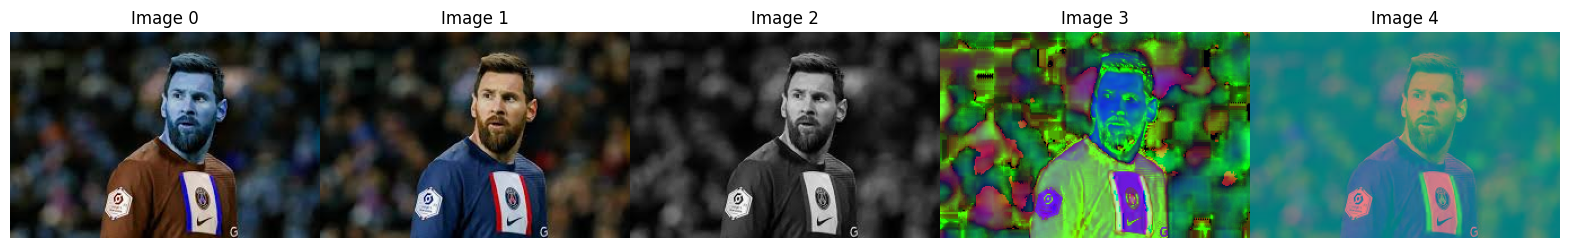

In [21]:
FileName = 'Messi1.jfif'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
img = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, img, image_gray, image_hsv, image_ycbcr], 1, 5)

In [10]:
def plot_RGB(img):
    R, G, B = 0, 1, 2
    img_RGB = np.array(img)
    fix, ax = plt.subplots(1, 4, figsize = (12,20))
    ax[0].imshow(np.array(img))
    ax[1].imshow(img_RGB[:,:,R], cmap=plt.get_cmap('Greys'))
    ax[2].imshow(img_RGB[:,:,G], cmap=plt.get_cmap('Greys'))
    ax[3].imshow(img_RGB[:,:,B], cmap=plt.get_cmap('Greys'))
    plt.show()

In [13]:
def plot_YCbCr(img):
    Y, Cb, Cr = 0, 1, 2
    img_YCbCr = color.rgb2ycbcr(img)
    fix, ax = plt.subplots(1, 4, figsize = (12,20))
    ax[0].imshow(np.array(img))
    ax[1].imshow(img_YCbCr[:,:,Y], cmap=plt.get_cmap('Greys'))
    ax[2].imshow(img_YCbCr[:,:,Cb], cmap=plt.get_cmap('Greys'))
    ax[3].imshow(img_YCbCr[:,:,Cr], cmap=plt.get_cmap('Greys'))
    plt.show()

In [14]:
def plot_HSV(img):
    H, S, V = 0, 1, 2
    img_HSL = color.rgb2hsv(img)
    fix, ax = plt.subplots(1, 4, figsize = (12,20))
    ax[0].imshow(np.array(img))
    ax[1].imshow(img_HSL[:,:,H], cmap=plt.get_cmap('Greys'))
    ax[2].imshow(img_HSL[:,:,S], cmap=plt.get_cmap('Greys'))
    ax[3].imshow(img_HSL[:,:,V], cmap=plt.get_cmap('Greys'))
    plt.show()

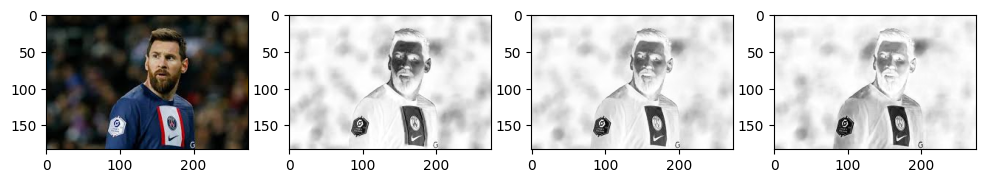

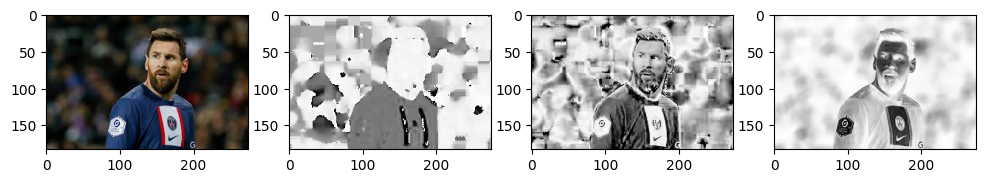

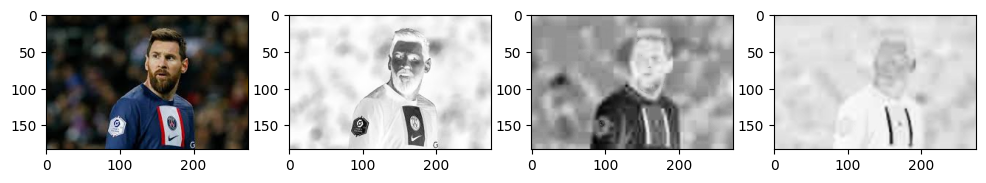

In [22]:
plot_RGB(img)
plot_HSV(img)
plot_YCbCr(img)

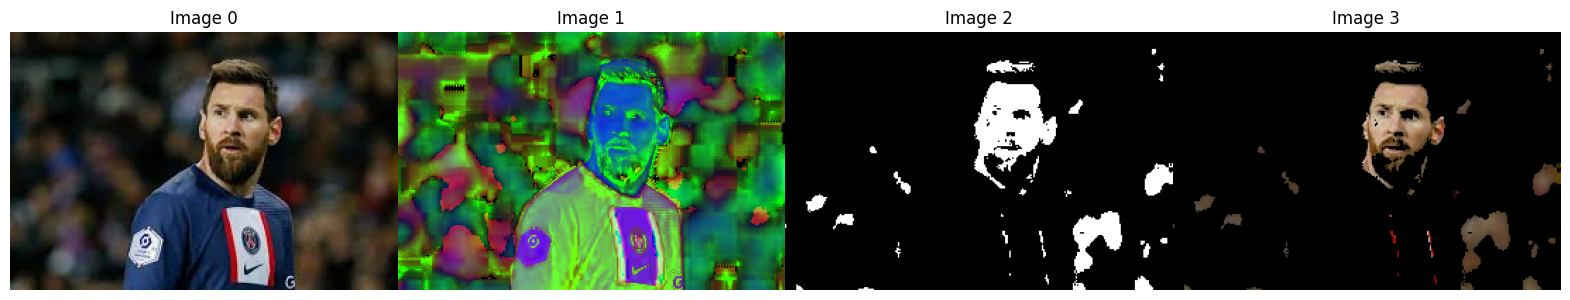

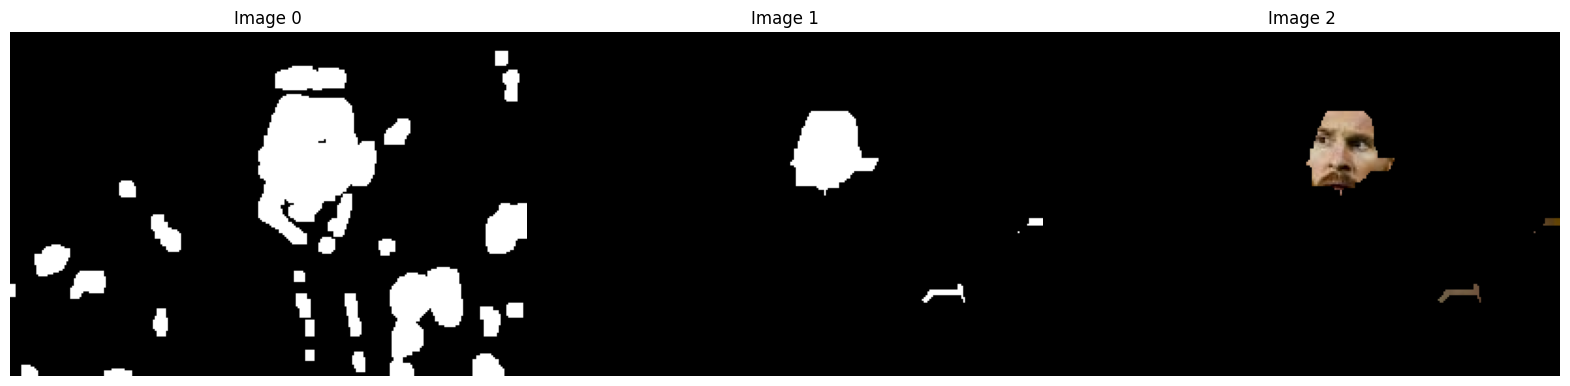

In [28]:
# define the upper and lower boundaries of the HSV pixel
# intensities to be considered 'skin' 
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")
skinMask = cv2.inRange(image_hsv, lower, upper)
skin = cv2.bitwise_and(img, img, mask=skinMask)
ShowImage([img, image_hsv, skinMask, skin], 1, 4)

se = square(5)
image_mask01 = dilation(skinMask, se)
image_mask02 = ndi.binary_fill_holes(image_mask01)
image_mask03 = erosion(image_mask02, square(15))
skin = cv2.bitwise_and(img, img, mask=image_mask03.astype(np.uint8))
ShowImage([image_mask01, image_mask03, skin], 1, 3)

In [29]:
image_label = label(image_mask03)
regions = regionprops(image_label, intensity_image=image_gray)
AttDataFrame = pd.DataFrame(columns=["LabelIndex", "Area", "Ratio", "BoundingBox"])
rowidx = 0
for props in regions:
    labelidx = props.label
    mask = image_label == labelidx
    area = props.area
    ratio = (area / (image_label.shape[0] * image_label.shape[1])) * 100
    bbox = props.bbox

    AttDataFrame.loc[rowidx, "LabelIndex"] = labelidx
    AttDataFrame.loc[rowidx, "Area"] = area
    AttDataFrame.loc[rowidx, "Ratio"] = ratio
    AttDataFrame.loc[rowidx, "BoundingBox"] = bbox
    rowidx = rowidx + 1

AttDataFrame = AttDataFrame.sort_values(by=['Area', 'Ratio'], ascending=False)
display(AttDataFrame)

,LabelIndex,Area,Ratio,BoundingBox
0,1,1294.0,2.571287,"(42, 140, 87, 187)"
3,4,83.0,0.164928,"(134, 210, 144, 233)"
1,2,33.0,0.065574,"(99, 266, 103, 275)"
2,3,1.0,0.001987,"(106, 261, 107, 262)"


,LabelIndex,Area,Ratio,BoundingBox
0,1,1294.0,2.571287,"(42, 140, 87, 187)"


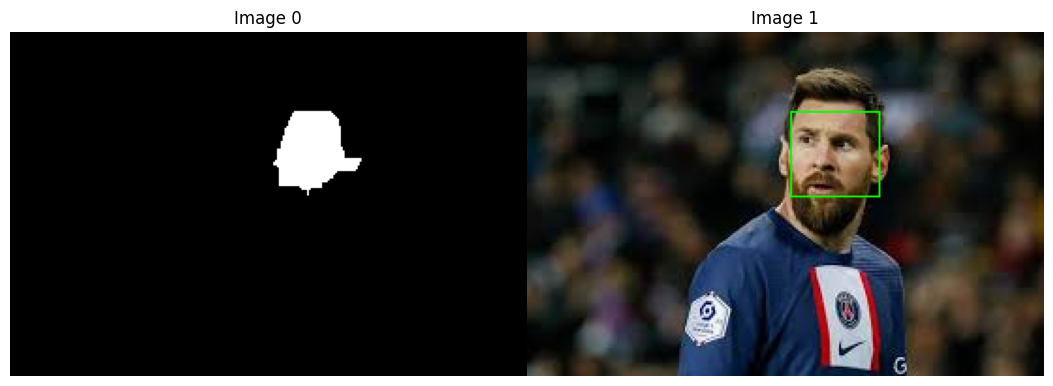

In [32]:
Condition = AttDataFrame["Ratio"] > 1.5
DF = AttDataFrame.loc[Condition]
DF = DF.reset_index(drop=True)
display(DF)

showface_img = img.copy()
skin_image = img.copy()
Face_Mask = []
for idx in range(DF.shape[0]):
    ixlabel = DF.loc[idx, "LabelIndex"]
    BBox = DF.loc[idx, "BoundingBox"]
    Face_Mask.append(image_label == ixlabel)
    minr, minc, maxr, maxc = BBox
    left_top = (minc, minr)
    right_bottom = (maxc, maxr)
    cv2.rectangle(showface_img, left_top, right_bottom, (0, 255, 0), 1)

ShowImage(Face_Mask + [showface_img], 1, 3)

Selected Image :  
Index  7 
Name  Ronaldo1.jfif


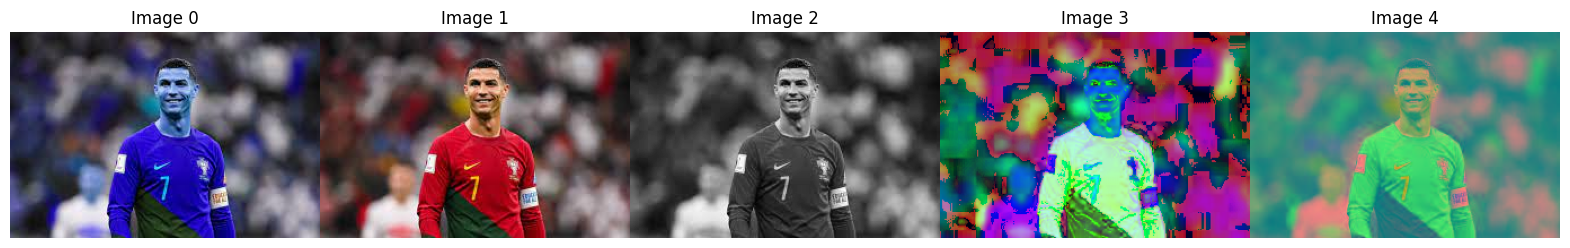

In [44]:
FileName = 'Ronaldo1.jfif'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
img = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, img, image_gray, image_hsv, image_ycbcr], 1, 5)

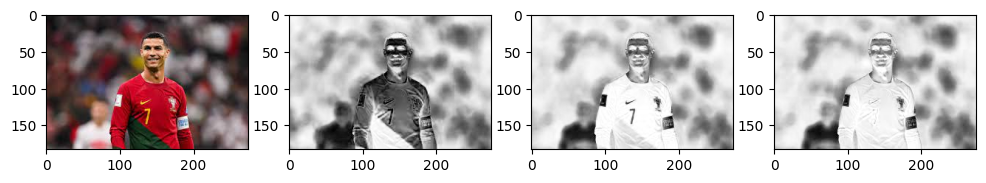

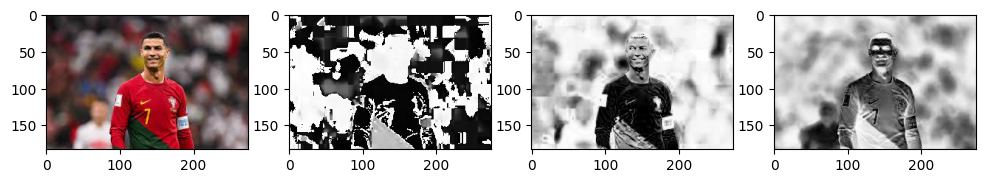

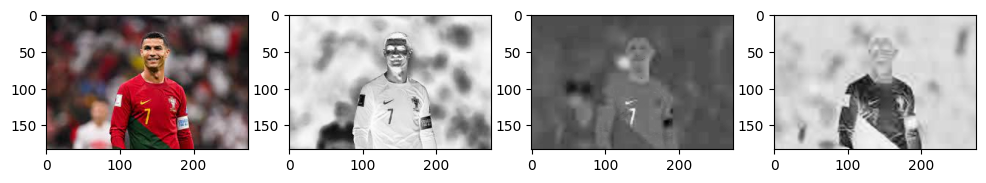

In [45]:
plot_RGB(img)
plot_HSV(img)
plot_YCbCr(img)

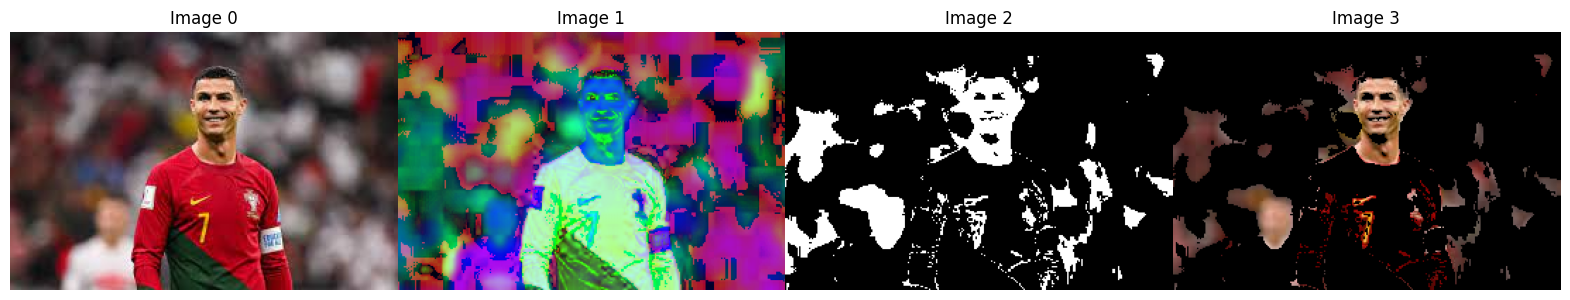

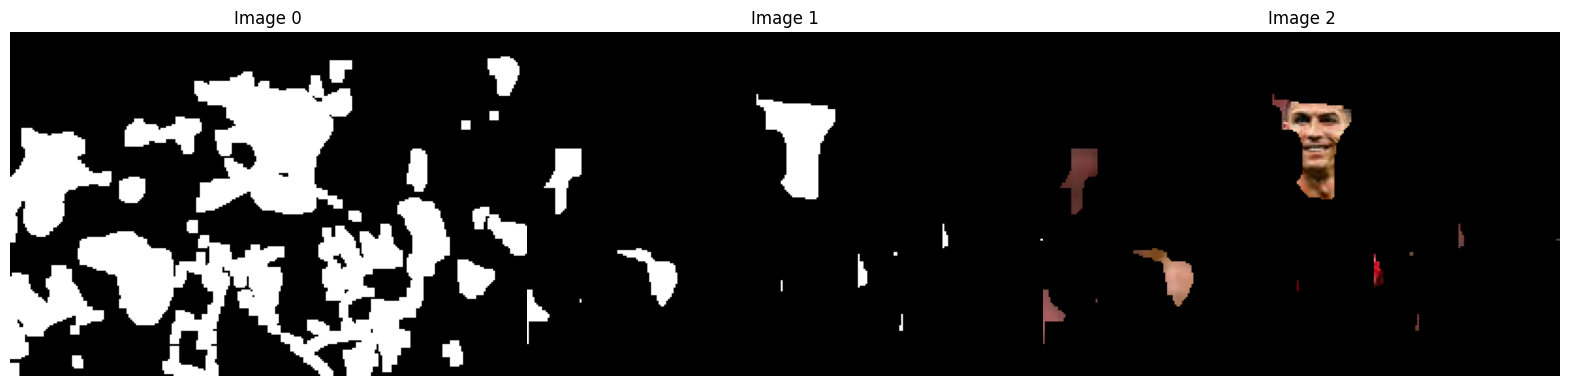

In [46]:
# define the upper and lower boundaries of the HSV pixel
# intensities to be considered 'skin' 
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")
skinMask = cv2.inRange(image_hsv, lower, upper)
skin = cv2.bitwise_and(img, img, mask=skinMask)
ShowImage([img, image_hsv, skinMask, skin], 1, 4)

se = square(5)
image_mask01 = dilation(skinMask, se)
image_mask02 = ndi.binary_fill_holes(image_mask01)
image_mask03 = erosion(image_mask02, square(15))
skin = cv2.bitwise_and(img, img, mask=image_mask03.astype(np.uint8))
ShowImage([image_mask01, image_mask03, skin], 1, 3)

In [47]:
image_label = label(image_mask03)
regions = regionprops(image_label, intensity_image=image_gray)
AttDataFrame = pd.DataFrame(columns=["LabelIndex", "Area", "Ratio", "BoundingBox"])
rowidx = 0
for props in regions:
    labelidx = props.label
    mask = image_label == labelidx
    area = props.area
    ratio = (area / (image_label.shape[0] * image_label.shape[1])) * 100
    bbox = props.bbox

    AttDataFrame.loc[rowidx, "LabelIndex"] = labelidx
    AttDataFrame.loc[rowidx, "Area"] = area
    AttDataFrame.loc[rowidx, "Ratio"] = ratio
    AttDataFrame.loc[rowidx, "BoundingBox"] = bbox
    rowidx = rowidx + 1

AttDataFrame = AttDataFrame.sort_values(by=['Area', 'Ratio'], ascending=False)
display(AttDataFrame)

,LabelIndex,Area,Ratio,BoundingBox
0,1,1198.0,2.380527,"(33, 122, 89, 164)"
4,5,363.0,0.721311,"(115, 48, 146, 80)"
1,2,360.0,0.71535,"(62, 9, 97, 29)"
8,9,130.0,0.258321,"(137, 0, 166, 12)"
6,7,60.0,0.119225,"(118, 176, 136, 181)"
2,3,27.0,0.053651,"(102, 221, 115, 224)"
10,11,12.0,0.023845,"(150, 198, 159, 200)"
7,8,6.0,0.011923,"(132, 135, 138, 136)"
5,6,4.0,0.007948,"(117, 195, 119, 197)"
3,4,2.0,0.003974,"(110, 273, 111, 275)"


,LabelIndex,Area,Ratio,BoundingBox
0,1,1198.0,2.380527,"(33, 122, 89, 164)"


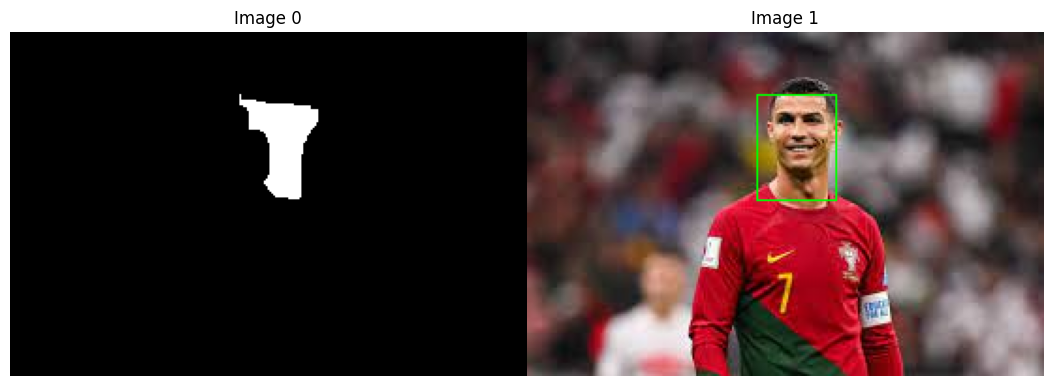

In [48]:
Condition = AttDataFrame["Ratio"] > 1.5
DF = AttDataFrame.loc[Condition]
DF = DF.reset_index(drop=True)
display(DF)

showface_img = img.copy()
skin_image = img.copy()
Face_Mask = []
for idx in range(DF.shape[0]):
    ixlabel = DF.loc[idx, "LabelIndex"]
    BBox = DF.loc[idx, "BoundingBox"]
    Face_Mask.append(image_label == ixlabel)
    minr, minc, maxr, maxc = BBox
    left_top = (minc, minr)
    right_bottom = (maxc, maxr)
    cv2.rectangle(showface_img, left_top, right_bottom, (0, 255, 0), 1)

ShowImage(Face_Mask + [showface_img], 1, 3)